In [46]:
import pandas as pd
#data loading 
raw = pd.read_csv("AAPL_10y_OHLCV.csv", header=None)## data downloaded from y finance. 

#data cleaning
raw = raw.drop(index=[0,1,2]).reset_index(drop=True)
raw.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

raw["Date"] = pd.to_datetime(raw["Date"], errors="coerce")
num_cols = ["Close", "High", "Low", "Open", "Volume"]
raw[num_cols] = raw[num_cols].apply(pd.to_numeric, errors="coerce")

raw = raw.dropna().sort_values("Date").reset_index(drop=True)
df_arima = raw.set_index("Date")

print(df_arima.head())

                Close       High        Low       Open     Volume
Date                                                             
2015-12-09  26.068718  26.535439  25.946965  26.524164  185445600
2015-12-10  26.192720  26.366332  26.043912  26.163410  116850800
2015-12-11  25.518581  26.016868  25.444176  25.971775  187544800
2015-12-14  25.360744  25.405838  24.754233  25.293103  257274800
2015-12-15  24.912066  25.432900  24.880500  25.238997  213292400


In [45]:
ts = df_arima["Close"]


<AxesSubplot:xlabel='Date'>

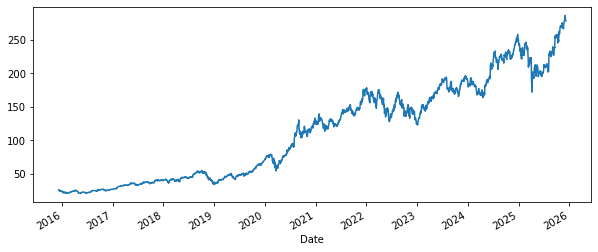

In [18]:
df_arima["Close"].plot(figsize=(10,4 # plotting the actual graph just for refrence 


### ARIMA Forecasting (Overview)

This cell builds an ARIMA model to predict Apple’s next-day closing prices.
- **Objective:**  
  Build a statistical baseline model (ARIMA) to forecast AAPL’s daily closing price using only its past values.

- **Input:**  
  Historical AAPL **Close** price time series.

- **Target:**  
  Next-day **Close** price during the test period.


### Motivation for Using ARIMA

Stock prices behave as time-dependent sequences where today’s value is strongly
influenced by past values. ARIMA is a classic statistical model specifically
designed for this type of data. It captures trends and autocorrelation in a
transparent, interpretable way.

### Why ARIMA?

- It models **temporal patterns** directly from past closing prices.  
- Provides a strong **baseline** before applying more complex ML models.  
- ARIMA works well for **short-term forecasting**, where patterns are smoother.  
- The model is fully interpretable (p, d, q terms show how much history matters).  
- It helps us understand the “pure” time-series behavior **without external features**.

Using ARIMA first establishes a reliable reference model, which we can then
compare against more advanced approaches like XGBoost.



**Steps performed:**
- Split data into **85% train / 15% test**.
- Use `auto_arima()` to automatically find the best (p, d, q) order.
- Perform **rolling 1-step forecasting** to mimic real-world prediction.
- Plot actual vs. predicted prices for visual evaluation.
- Compute key metrics (RMSE, MAE, R², MAPE, Accuracy) to measure model performance.

This serves as a strong statistical baseline model for time-series forecasting.


Train: 2136  Test: 378
Best ARIMA order: (0, 1, 0)


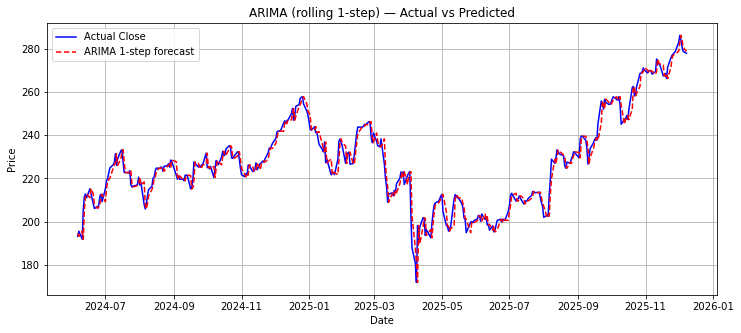

RMSE: 3.9980018995375928
MAE : 2.721510266500806
R²  : 0.9640117158261392
MAPE: 1.2244898273753813
Accuracy (%): 98.77551017262462


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# 1) Use only the Close price for ARIMA modeling
ts = df_arima["Close"]

# 85% training and 15% testing split
train_size = int(len(ts) * 0.85)
train = ts[:train_size]
test  = ts[train_size:]
print("Train:", len(train), " Test:", len(test))

# 2) Automatically find the best ARIMA (p,d,q) order using only training data
# auto_arima runs several combinations and picks the one with lowest AIC
auto_model = pm.auto_arima(
    train,
    seasonal=False,
    stepwise=True,
    trace=False,
    suppress_warnings=True,
    max_p=6, max_q=6, max_d=2
)
order = auto_model.order
print("Best ARIMA order:", order)

# 3) Rolling 1-step forecasting
# We forecast one day at a time and update the model with actual observed values
history = list(train)
pred_prices = []

for y_true in test:
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    
    # next-day prediction
    yhat = model_fit.forecast()[0]
    pred_prices.append(yhat)
    
    # append the true value (not predicted) to maintain realism
    history.append(y_true)

pred_prices = np.array(pred_prices)
actual_prices = test.values
dates = test.index

# 4) Plot actual vs predicted values
plt.figure(figsize=(12,5))
plt.plot(dates, actual_prices, label="Actual Close", color="blue")
plt.plot(dates, pred_prices, label="ARIMA 1-step forecast", color="red", linestyle="--")
plt.title("ARIMA (rolling 1-step) — Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

# 5) Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(actual_prices, pred_prices))
mae  = mean_absolute_error(actual_prices, pred_prices)
r2   = r2_score(actual_prices, pred_prices)
mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100
accuracy = 100 - mape

# Display results
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)
print("MAPE:", mape)
print("Accuracy (%):", accuracy)


**ARIMA performance (test period)**  

- RMSE ≈ **4.00**, MAE ≈ **2.72**, MAPE ≈ **1.22%**, Accuracy ≈ **98.78%**, R² ≈ **0.964**  

This means the ARIMA model’s daily predictions are, on average, only about **1.2% away** from the actual AAPL closing price, and it explains roughly **96% of the variance** in the test data. Overall, ARIMA provides a **very strong and stable baseline forecast** for the price level.


### Next 7 day projection for Arima

Train returns: 2136  Test returns: 377
Best ARIMA order on returns: (0, 0, 1)
Next 7-day ARIMA (return-based) forecast:
2025-12-09    278.221115
2025-12-10    278.482960
2025-12-11    278.745052
2025-12-12    279.007390
2025-12-15    279.269976
2025-12-16    279.532808
2025-12-17    279.795888
Freq: B, Name: predicted_mean, dtype: float64


/Users/anujatalekar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anujatalekar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anujatalekar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/anujatalekar/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given wit

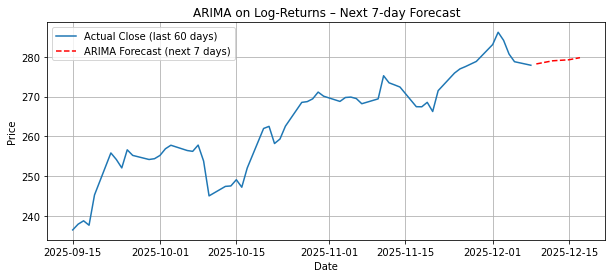

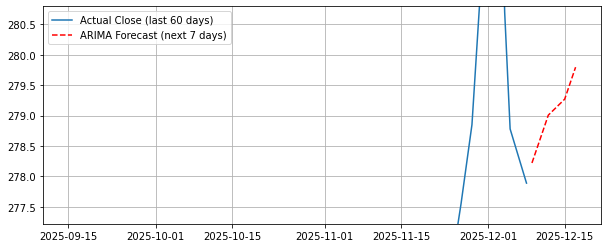

In [26]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# 1) Work with log prices and log-returns
close = df_arima["Close"].astype(float)
log_close = np.log(close)
log_ret = log_close.diff().dropna()   # log-returns ~ stationary

# 2) Train/test split on RETURNS (if you want to evaluate, optional)
train_size = int(len(log_ret) * 0.85)
train_ret = log_ret[:train_size]
test_ret  = log_ret[train_size:]

print("Train returns:", len(train_ret), " Test returns:", len(test_ret))

# 3) auto_arima on RETURNS (d=0 because we already differenced)
auto_model = pm.auto_arima(
    train_ret,
    d=0,
    seasonal=False,
    stepwise=True,
    trace=False,
    suppress_warnings=True,
    max_p=6, max_q=6
)
order = auto_model.order
print("Best ARIMA order on returns:", order)

# 4) Fit ARIMA on ALL returns for forecasting
model_ret = ARIMA(log_ret, order=order).fit()

# 5) Forecast next 7 log-returns
n_steps = 7
future_log_ret = model_ret.forecast(steps=n_steps)

# 6) Convert forecasted log-returns back to price path
last_log_price = log_close.iloc[-1]
future_log_prices = last_log_price + np.cumsum(future_log_ret)
future_prices = np.exp(future_log_prices)

# Build a proper date index (business days)
future_index = pd.date_range(
    start=close.index[-1] + pd.tseries.offsets.BDay(1),
    periods=n_steps,
    freq="B"
)
future_prices.index = future_index

print("Next 7-day ARIMA (return-based) forecast:")
print(future_prices)

# 7) Plot last 60 days + 7-day forecast
plt.figure(figsize=(10,4))
plt.plot(close.tail(60), label="Actual Close (last 60 days)")
plt.plot(future_prices, label="ARIMA Forecast (next 7 days)", linestyle="--", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("ARIMA on Log-Returns – Next 7-day Forecast")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(close.tail(60), label="Actual Close (last 60 days)")
plt.plot(future_prices, label="ARIMA Forecast (next 7 days)", linestyle="--", color="red")
plt.ylim(future_prices.min()-1, future_prices.max()+1)  # zoom around forecast
plt.grid(True); plt.legend(); plt.show()




### XGBoost Model — Objective, Inputs, and Targets

**Objective:**  
To predict the *next-day closing price of AAPL stock* using an advanced machine-learning model capable of learning nonlinear relationships in financial time-series data.

**Inputs (Features):**  
The model uses a wide range of engineered features that capture price behavior, momentum, volatility, and historical patterns:

- Raw market variables: **Open, High, Low, Close, Volume**
- Returns-based features: **Return, Log_Return**
- Trend indicators: **SMA_10, SMA_20, SMA_50**
- Momentum indicators: **EMA_12, EMA_26, MACD**
- Overbought/oversold indicator: **RSI**
- Volatility measures: **Vol_10, Vol_20**
- Historical dependencies: **Lagged Close values (Lag_1, Lag_2, … Lag_10)**
- Lagged returns: **Ret_Lag_1, Ret_Lag_2, Ret_Lag_3**

These features allow the model to learn complex interactions that are not captured by simple linear models.

**Target Variable:**  
The **actual closing price** of the stock on the same day (used as `Target`).  
This enables XGBoost to learn a supervised regression mapping between today’s features and today’s closing price.

### Motivation for Using XGBoost

Financial markets are nonlinear and influenced by multiple interacting factors such
as momentum, volatility, trends, and historical price patterns. Unlike simple
time-series models, machine-learning algorithms can capture these complex
relationships more effectively.

### Why XGBoost?

- Handles **nonlinear patterns** in stock price movements that ARIMA cannot model.  
- Works well with engineered features such as RSI, MACD, volatility, and lag values.  
- Robust to noise and overfitting, which is important for market data.  
- Provides **feature importance**, giving insight into which indicators matter most.  
- Often achieves **higher predictive performance**, especially in trend and direction forecasting.

XGBoost complements ARIMA by incorporating rich technical indicators and learning
from deeper patterns in the data.



In [20]:
import pandas as pd

raw = pd.read_csv("AAPL_10y_OHLCV.csv", header=None)

#drop first 3 rows
raw = raw.drop(index=[0, 1, 2]).reset_index(drop=True)

#set column names
raw.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

#convert types
raw["Date"] = pd.to_datetime(raw["Date"], errors="coerce")
num_cols = ["Close", "High", "Low", "Open", "Volume"]
raw[num_cols] = raw[num_cols].apply(pd.to_numeric, errors="coerce")

#remove bad rows, sort, set index
raw = raw.dropna().sort_values("Date").reset_index(drop=True)
df_arima = raw.set_index("Date")   # base price dataframe

print(df_arima.head())
print(df_arima.info())


                Close       High        Low       Open     Volume
Date                                                             
2015-12-09  26.068718  26.535439  25.946965  26.524164  185445600
2015-12-10  26.192720  26.366332  26.043912  26.163410  116850800
2015-12-11  25.518581  26.016868  25.444176  25.971775  187544800
2015-12-14  25.360744  25.405838  24.754233  25.293103  257274800
2015-12-15  24.912066  25.432900  24.880500  25.238997  213292400
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2015-12-09 to 2025-12-08
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2514 non-null   float64
 1   High    2514 non-null   float64
 2   Low     2514 non-null   float64
 3   Open    2514 non-null   float64
 4   Volume  2514 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.8 KB
None


In [21]:
import numpy as np

df_xgb = df_arima.copy()

#returns
df_xgb["Return"] = df_xgb["Close"].pct_change()
df_xgb["Log_Return"] = np.log(df_xgb["Close"] / df_xgb["Close"].shift(1))

#moving averages
df_xgb["SMA_10"] = df_xgb["Close"].rolling(10).mean()
df_xgb["SMA_20"] = df_xgb["Close"].rolling(20).mean()
df_xgb["SMA_50"] = df_xgb["Close"].rolling(50).mean()

#EMAs & MACD
df_xgb["EMA_12"] = df_xgb["Close"].ewm(span=12, adjust=False).mean()
df_xgb["EMA_26"] = df_xgb["Close"].ewm(span=26, adjust=False).mean()
df_xgb["MACD"]   = df_xgb["EMA_12"] - df_xgb["EMA_26"]

#RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain, index=series.index).rolling(period).mean()
    avg_loss = pd.Series(loss, index=series.index).rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df_xgb["RSI"] = compute_rsi(df_xgb["Close"])

#Volatility
df_xgb["Vol_10"] = df_xgb["Close"].rolling(10).std()
df_xgb["Vol_20"] = df_xgb["Close"].rolling(20).std()

#Lags of Close
for k in [1, 2, 3, 5, 7, 10]:
    df_xgb[f"Lag_{k}"] = df_xgb["Close"].shift(k)

#Lags of Return
for k in [1, 2, 3]:
    df_xgb[f"Ret_Lag_{k}"] = df_xgb["Return"].shift(k)

#target = today's Close
df_xgb["Target"] = df_xgb["Close"]

#drop NaNs from rolling/shift
df_xgb = df_xgb.dropna()

print(df_xgb.head())
print("Shape:", df_xgb.shape)


                Close       High        Low       Open     Volume    Return  \
Date                                                                          
2016-02-22  21.961954  21.966489  21.744330  21.832740  137123200  0.008746   
2016-02-23  21.465504  21.875816  21.433767  21.853147  127770400 -0.022605   
2016-02-24  21.785137  21.848611  21.154933  21.304550  145022800  0.014891   
2016-02-25  21.934753  21.934753  21.592447  21.773802  110330800  0.006868   
2016-02-26  21.968761  22.220388  21.893953  22.034501  115964400  0.001550   

            Log_Return     SMA_10     SMA_20     SMA_50  ...      Lag_1  \
Date                                                     ...              
2016-02-22    0.008708  21.669524  21.693281  22.834507  ...  21.771540   
2016-02-23   -0.022864  21.662270  21.645525  22.742443  ...  21.961954   
2016-02-24    0.014781  21.687433  21.607550  22.654291  ...  21.465504   
2016-02-25    0.006844  21.743879  21.651122  22.582615  ...  21.785137

### Why We Used Technical Indicators, Returns, Lags, and Volatility Features

Stock prices are influenced by several dynamic factors such as momentum, trend strength, volatility, and recent historical patterns.  
To capture these complex behaviors, we engineered a diverse set of features commonly used in quantitative finance:

#### **1. Momentum Indicators (MACD, RSI, EMAs)**  
These help the model understand whether the stock is gaining upward momentum, slowing down, or entering overbought/oversold regions — patterns that commonly precede reversals or trend continuations.

#### **2. Trend Indicators (SMAs, EMAs)**  
Moving averages smooth out noise and help the model identify broader price directions instead of reacting to short-term fluctuations.

#### **3. Volatility Indicators (Vol_10, Vol_20)**  
High volatility often leads to larger price swings. Including volatility helps the model adjust expectations in turbulent vs. stable periods.

#### **4. Returns & Log Returns**  
These stabilize the scale of price movements and make the data more stationary, which helps machine-learning models learn more reliable patterns.

#### **5. Lag Features (Lag_1 to Lag_10)**  
Stock prices exhibit autocorrelation — today's price is highly dependent on previous days.  
Lagged features give the model direct access to recent historical behavior.

### **Overall Benefit**  
By combining these indicators, the model can learn:  
- trends,  
- reversals,  
- volatility shifts,  
- short-term patterns,  
- and nonlinear interactions  

making XGBoost significantly more expressive and powerful than using raw prices alone.

---


In [22]:
df_xgb_10y = df_xgb.copy()


Train rows: 1963 Test rows: 502
XGBoost (10y, train = all except 2023–2024, test = 2023–2024) performance:
RMSE: 4.581475167366499
MAE : 2.9602649582334717
R²  : 0.9733912102951328
MAPE: 1.5633912127156622
Accuracy (%): 98.43660878728434


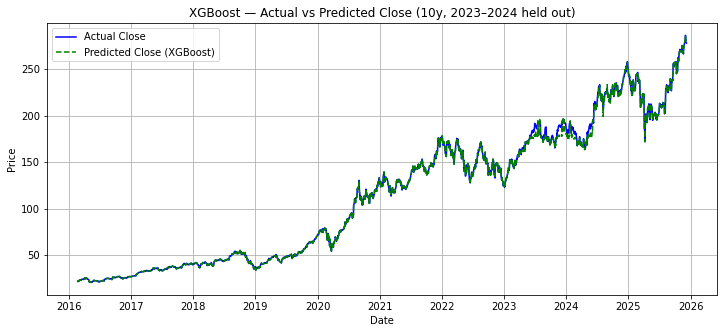

In [23]:
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

feature_cols = [
    "Open", "High", "Low", "Volume",
    "Return", "Log_Return",
    "SMA_10", "SMA_20", "SMA_50",
    "EMA_12", "EMA_26",
    "MACD", "RSI",
    "Vol_10", "Vol_20",
    "Lag_1", "Lag_2", "Lag_3", "Lag_5", "Lag_7", "Lag_10",
    "Ret_Lag_1", "Ret_Lag_2", "Ret_Lag_3"
]

X = df_xgb_10y[feature_cols]
y = df_xgb_10y["Target"]

idx = df_xgb_10y.index

#test period = 2023 + 2024
test_mask = (idx >= "2023-01-01") & (idx <= "2024-12-31")

#train on everything else (2016–2022 and 2025+ inside the 10y slice)
train_mask = ~test_mask

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

print("Train rows:", len(X_train), "Test rows:", len(X_test))

#scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

model_xgb = XGBRegressor(
    n_estimators=1200,
    learning_rate=0.02,
    max_depth=7,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=0.5,
    objective="reg:squarederror",
    random_state=42,
)

model_xgb.fit(X_train_scaled, y_train)

#predictions on full 10y window
X_all_scaled = scaler.transform(X)
pred_all = model_xgb.predict(X_all_scaled)

# metrics on 2023–2024 only
pred_test = model_xgb.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae  = mean_absolute_error(y_test, pred_test)
r2   = r2_score(y_test, pred_test)
mape = np.mean(np.abs((y_test - pred_test) / y_test)) * 100
accuracy = 100 - mape

print("XGBoost (10y, train = all except 2023–2024, test = 2023–2024) performance:")
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)
print("MAPE:", mape)
print("Accuracy (%):", accuracy)

#plot full 10y
dates_10y  = df_xgb_10y.index
actual_10y = df_xgb_10y["Close"].values

plt.figure(figsize=(12,5))
plt.plot(dates_10y, actual_10y, label="Actual Close", color="blue")
plt.plot(dates_10y, pred_all, label="Predicted Close (XGBoost)",
         color="green", linestyle="--")
plt.title("XGBoost — Actual vs Predicted Close (10y, 2023–2024 held out)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

In [24]:
import numpy as np
import pandas as pd

#get raw importances from XGBoost
importances = model_xgb.feature_importances_

#put into a DataFrame for easier handling
fi_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
})

#sort descending
fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)

#compute percentage importance
fi_df["importance_pct"] = fi_df["importance"] / fi_df["importance"].sum() * 100

print(fi_df)
print("\nTop 10 features:")
print(fi_df.head(10))


       feature  importance  importance_pct
0         High    0.259175       25.917534
1         Open    0.243086       24.308643
2       SMA_10    0.207047       20.704693
3          Low    0.134382       13.438227
4        Lag_2    0.093839        9.383862
5        Lag_1    0.028380        2.837968
6       SMA_50    0.013501        1.350067
7        Lag_7    0.010296        1.029583
8       SMA_20    0.005620        0.562043
9       EMA_12    0.002481        0.248091
10       Lag_3    0.000926        0.092625
11       Lag_5    0.000589        0.058916
12      Lag_10    0.000443        0.044327
13      EMA_26    0.000129        0.012881
14  Log_Return    0.000036        0.003577
15      Return    0.000031        0.003075
16         RSI    0.000007        0.000658
17      Vol_10    0.000006        0.000575
18   Ret_Lag_1    0.000006        0.000565
19      Vol_20    0.000005        0.000531
20      Volume    0.000004        0.000421
21        MACD    0.000004        0.000405
22   Ret_La

Top 10 features by importance:
  feature  importance  importance_pct
0    High    0.259175       25.917534
1    Open    0.243086       24.308643
2  SMA_10    0.207047       20.704693
3     Low    0.134382       13.438227
4   Lag_2    0.093839        9.383862
5   Lag_1    0.028380        2.837968
6  SMA_50    0.013501        1.350067
7   Lag_7    0.010296        1.029583
8  SMA_20    0.005620        0.562043
9  EMA_12    0.002481        0.248091


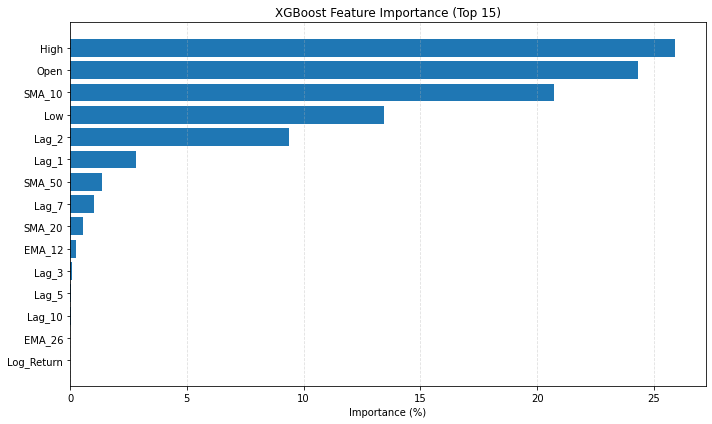

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#get feature importances from the trained XGBoost model
importances = model_xgb.feature_importances_

fi_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
})

#sort and turn into percentages
fi_df = fi_df.sort_values("importance", ascending=False).reset_index(drop=True)
fi_df["importance_pct"] = fi_df["importance"] / fi_df["importance"].sum() * 100

print("Top 10 features by importance:")
print(fi_df.head(10))

#plot top N features
N = 15
topN = fi_df.head(N)

plt.figure(figsize=(10, 6))
plt.barh(topN["feature"], topN["importance_pct"])
plt.gca().invert_yaxis()  # most important at the top
plt.xlabel("Importance (%)")
plt.title("XGBoost Feature Importance (Top 15)")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


### Importance of Feature Engineering in Stock Price Prediction

Financial markets are **nonlinear and highly noisy**, meaning raw price data alone does not provide enough structure for a machine-learning model to learn meaningful patterns.  
Feature engineering allows us to extract financial intuition and embed it directly into the model through:

- **Momentum** (RSI, MACD, EMAs)  
- **Trend strength** (SMAs)  
- **Volatility regimes** (rolling standard deviation)  
- **Historical influence** (lag features)  
- **Normalized changes** (returns)

This enriched feature set converts raw chaotic price movements into **interpretable signals**, enabling XGBoost to outperform traditional statistical models like ARIMA, especially in capturing nonlinear market behavior.

---


### Next 7 day projection for XGBoost

Next 7-day XGBoost forecast:
            Predicted_Close_XGB
2025-12-09           277.888733
2025-12-10           273.365051
2025-12-11           271.478699
2025-12-12           272.214844
2025-12-15           272.562103
2025-12-16           271.867065
2025-12-17           269.972748


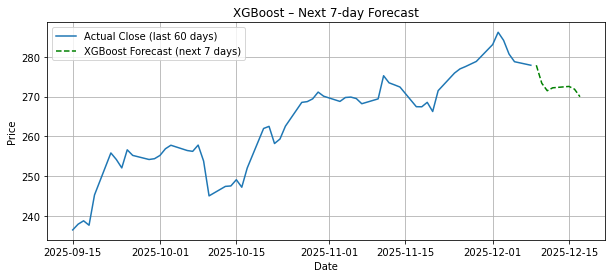

In [27]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay

# ---------- helper: recompute all features from price df ----------
def make_features_from_price(df_price):
    df = df_price.copy()

    # basic returns
    df["Return"] = df["Close"].pct_change()
    df["Log_Return"] = np.log(df["Close"] / df["Close"].shift(1))

    # moving averages
    df["SMA_10"] = df["Close"].rolling(10).mean()
    df["SMA_20"] = df["Close"].rolling(20).mean()
    df["SMA_50"] = df["Close"].rolling(50).mean()

    # EMAs & MACD
    df["EMA_12"] = df["Close"].ewm(span=12, adjust=False).mean()
    df["EMA_26"] = df["Close"].ewm(span=26, adjust=False).mean()
    df["MACD"]   = df["EMA_12"] - df["EMA_26"]

    # RSI
    def compute_rsi(series, period=14):
        delta = series.diff()
        gain = np.where(delta > 0, delta, 0)
        loss = np.where(delta < 0, -delta, 0)
        avg_gain = pd.Series(gain, index=series.index).rolling(period).mean()
        avg_loss = pd.Series(loss, index=series.index).rolling(period).mean()
        rs = avg_gain / (avg_loss + 1e-9)  # avoid div/0
        return 100 - (100 / (1 + rs))

    df["RSI"] = compute_rsi(df["Close"])

    # volatility
    df["Vol_10"] = df["Close"].rolling(10).std()
    df["Vol_20"] = df["Close"].rolling(20).std()

    # lags of Close
    for k in [1, 2, 3, 5, 7, 10]:
        df[f"Lag_{k}"] = df["Close"].shift(k)

    # lags of Return
    for k in [1, 2, 3]:
        df[f"Ret_Lag_{k}"] = df["Return"].shift(k)

    df = df.dropna()
    return df

# ---------- start from last 10 years of price data ----------
price_hist = df_arima.last("10Y").copy()

future_dates = []
future_preds_xgb = []

steps_ahead = 7

for step in range(steps_ahead):
    # 1) Recompute features on current history
    feat_df = make_features_from_price(price_hist)
    X_last = feat_df[feature_cols].iloc[-1:]   # last row

    # 2) Scale + predict next-day Close
    X_last_scaled = scaler.transform(X_last)
    next_close = model_xgb.predict(X_last_scaled)[0]

    # 3) Decide next date (next business day)
    last_date = price_hist.index[-1]
    next_date = last_date + BDay(1)

    future_dates.append(next_date)
    future_preds_xgb.append(next_close)

    # 4) Append synthetic OHLCV row for the predicted day
    #    (simple assumption: Open=High=Low=Close, Volume same as last day)
    new_row = pd.DataFrame({
        "Open":   [next_close],
        "High":   [next_close],
        "Low":    [next_close],
        "Close":  [next_close],
        "Volume": [price_hist["Volume"].iloc[-1]]
    }, index=[next_date])

    price_hist = pd.concat([price_hist, new_row])

# Collect results
future_xgb_df = pd.DataFrame(
    {"Predicted_Close_XGB": future_preds_xgb},
    index=future_dates
)

print("Next 7-day XGBoost forecast:")
print(future_xgb_df)

# Optional: plot last 60 days + 7-day XGBoost forecast
plt.figure(figsize=(10,4))
plt.plot(df_arima["Close"].tail(60), label="Actual Close (last 60 days)")
plt.plot(future_xgb_df["Predicted_Close_XGB"], label="XGBoost Forecast (next 7 days)",
         linestyle="--", color="green")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("XGBoost – Next 7-day Forecast")
plt.grid(True)
plt.legend()
plt.show()


### Comparison of both models 


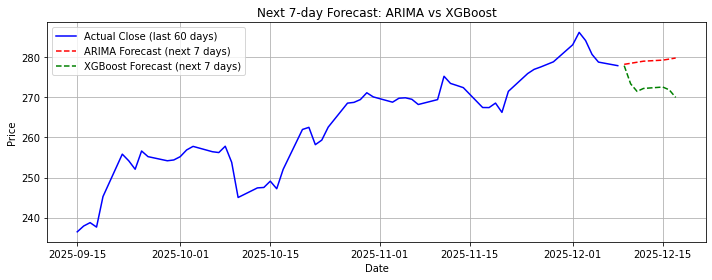

In [28]:
import matplotlib.pyplot as plt

# Actual last 60 days
actual_60 = df_arima["Close"].tail(60)

# Short aliases for forecasts
arima_forecast = future_prices              # Series
xgb_forecast   = future_xgb_df["Predicted_Close_XGB"]  # Series

plt.figure(figsize=(10,4))

# Actual
plt.plot(actual_60.index, actual_60.values,
         label="Actual Close (last 60 days)", color="blue")

# ARIMA forecast
plt.plot(arima_forecast.index, arima_forecast.values,
         label="ARIMA Forecast (next 7 days)", linestyle="--", color="red")

# XGBoost forecast
plt.plot(xgb_forecast.index, xgb_forecast.values,
         label="XGBoost Forecast (next 7 days)", linestyle="--", color="green")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Next 7-day Forecast: ARIMA vs XGBoost")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



### Comparison of metrics of both algorithms

In [30]:
pred_prices = np.array(pred_prices)   # ARIMA predictions
actual_prices = test.values           # true values
dates = test.index                    # test dates


In [31]:
# standard names for comparison
y_true_arima   = actual_prices        # true test values from ARIMA split
y_pred_arima   = pred_prices          # ARIMA predictions
dates_arima    = dates                # ARIMA test dates


In [32]:
y_true_xgb  = y_test.values           # or np.array(y_test)
y_pred_xgb  = pred_test
dates_xgb   = X_test.index            # if your X_test has DateTimeIndex


In [33]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, r2, mape

m_arima = metrics(y_true_arima, y_pred_arima)
m_xgb   = metrics(y_true_xgb,  y_pred_xgb)

df_compare = pd.DataFrame(
    [m_arima, m_xgb],
    index=["ARIMA", "XGBoost"],
    columns=["RMSE", "MAE", "R²", "MAPE"]
)

print(df_compare)


             RMSE       MAE        R²      MAPE
ARIMA    3.998002  2.721510  0.964012  1.224490
XGBoost  4.581475  2.960265  0.973391  1.563391


**Interpretation:**

- ARIMA has **slightly lower RMSE/MAE/MAPE**, so its **point forecasts are a bit
  closer in absolute price terms**.  
- XGBoost has a **slightly higher R²**, meaning it explains a bit more of the
  variation in prices overall.  

Both models perform very well; ARIMA is marginally better for **pure price-level
accuracy**, while XGBoost is marginally better at **capturing variance and
directional moves**.


### Prediction of error over time

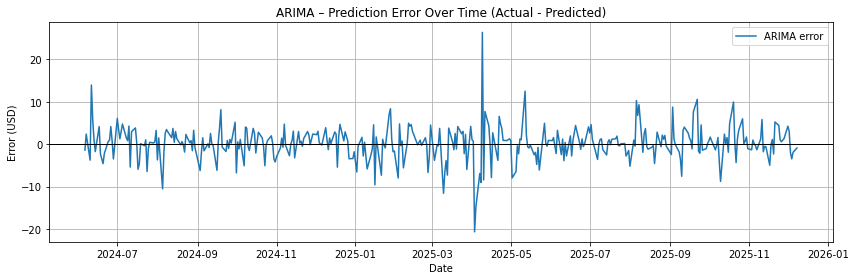

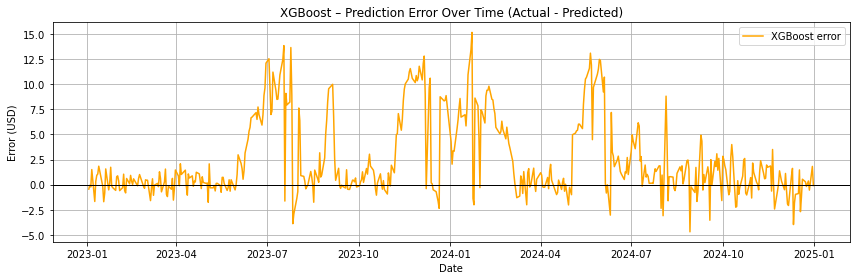

In [35]:
import numpy as np
import matplotlib.pyplot as plt

err_arima = y_true_arima - y_pred_arima
err_xgb   = y_true_xgb   - y_pred_xgb

plt.figure(figsize=(12,4))
plt.plot(dates_arima, err_arima, label="ARIMA error")
plt.axhline(0, color="black", linewidth=1)
plt.title("ARIMA – Prediction Error Over Time (Actual - Predicted)")
plt.xlabel("Date")
plt.ylabel("Error (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(dates_xgb, err_xgb, label="XGBoost error", color="orange")
plt.axhline(0, color="black", linewidth=1)
plt.title("XGBoost – Prediction Error Over Time (Actual - Predicted)")
plt.xlabel("Date")
plt.ylabel("Error (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



**Prediction error over time (Actual − Predicted)**  

- Y-axis: error in USD (0 = perfect prediction).  
  - Positive error → model under-predicts (actual > predicted).  
  - Negative error → model over-predicts (actual < predicted).  

- **ARIMA (top panel)**  
  - Errors fluctuate around 0 with frequent swings both above and below.  
  - A few large spikes show days where ARIMA badly misses sudden moves.  
  - Overall behaviour is fairly noisy and symmetric, indicating no strong
    systematic bias but higher day-to-day variability.

- **XGBoost (bottom panel)**  
  - Errors are more clustered and often stay on the positive side, meaning the
    model tends to **under-predict** during strong upward trends.  
  - The magnitude of errors is generally smaller than the largest ARIMA spikes,
    but there are periods where XGBoost consistently underestimates rising
    prices.


### Residual Disrtribution

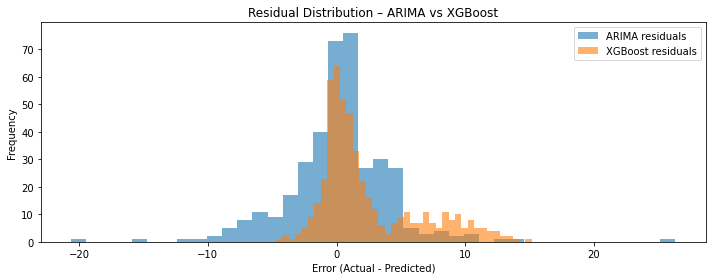

In [36]:
plt.figure(figsize=(10,4))
plt.hist(err_arima, bins=40, alpha=0.6, label="ARIMA residuals")
plt.hist(err_xgb,   bins=40, alpha=0.6, label="XGBoost residuals")
plt.title("Residual Distribution – ARIMA vs XGBoost")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


**Residual distribution – ARIMA vs XGBoost**

- X-axis: forecasting error = Actual − Predicted  
  - 0 ⇒ perfect prediction  
  - Positive error ⇒ model **under-predicts** (actual > predicted)  
  - Negative error ⇒ model **over-predicts** (actual < predicted)  
- Y-axis: how often each error size occurs.

From the histograms:
- **ARIMA residuals (blue)** are wider and spread on both sides → larger and more
  variable errors (both big over- and under-predictions).  
- **XGBoost residuals (orange)** are more concentrated but slightly shifted to the
  right → it tends to **under-predict** prices a bit, but with generally smaller
  error variance than ARIMA.


### Checking the Directional accuracy for both of them

In [37]:
# convert to numpy arrays
y_true_arima_arr = np.array(y_true_arima).flatten()
y_pred_arima_arr = np.array(y_pred_arima).flatten()

y_true_xgb_arr = np.array(y_true_xgb).flatten()
y_pred_xgb_arr = np.array(y_pred_xgb).flatten()

# 1-step returns (difference sign)
ret_true_arima  = np.sign(np.diff(y_true_arima_arr))
ret_pred_arima  = np.sign(np.diff(y_pred_arima_arr))

ret_true_xgb    = np.sign(np.diff(y_true_xgb_arr))
ret_pred_xgb    = np.sign(np.diff(y_pred_xgb_arr))

dir_acc_arima = (ret_true_arima == ret_pred_arima).mean() * 100
dir_acc_xgb   = (ret_true_xgb   == ret_pred_xgb).mean() * 100

print(f"Directional accuracy (up/down correct):")
print(f"  ARIMA  : {dir_acc_arima:.2f}%")
print(f"  XGBoost: {dir_acc_xgb:.2f}%")


Directional accuracy (up/down correct):
  ARIMA  : 52.52%
  XGBoost: 79.44%


**Directional accuracy (up/down correct)**  

- ARIMA: **52.52%** → only slightly better than random (50%), so ARIMA is weak at
  predicting whether the next day’s price will go up or down.  
- XGBoost: **79.44%** → correctly predicts the direction of the move most of the
  time, showing that the feature-based ML model captures trend/momentum patterns
  much better than ARIMA.


### Actual vs Predicted scatter (who hugs the diagonal more)

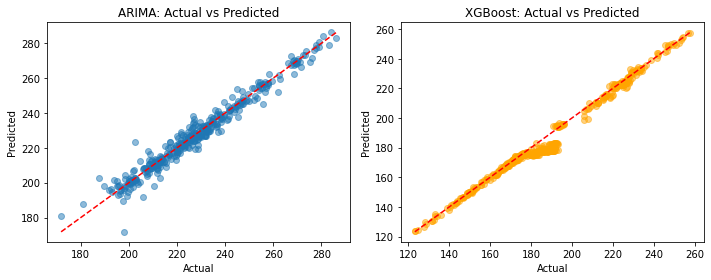

In [38]:
plt.figure(figsize=(10,4))

# ARIMA
plt.subplot(1,2,1)
plt.scatter(y_true_arima_arr, y_pred_arima_arr, alpha=0.5)
min_val = min(y_true_arima_arr.min(), y_pred_arima_arr.min())
max_val = max(y_true_arima_arr.max(), y_pred_arima_arr.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.title("ARIMA: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# XGBoost
plt.subplot(1,2,2)
plt.scatter(y_true_xgb_arr, y_pred_xgb_arr, alpha=0.5, color="orange")
min_val = min(y_true_xgb_arr.min(), y_pred_xgb_arr.min())
max_val = max(y_true_xgb_arr.max(), y_pred_xgb_arr.max())
plt.plot([min_val, max_val], [min_val, max_val], "r--")
plt.title("XGBoost: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()



**Actual vs Predicted Scatter Plots**

- X-axis: actual closing price (test period)  
- Y-axis: model’s predicted closing price  
- Red dashed line: perfect prediction (y = x)  
- Points on the line → almost exact prediction  
- Points above the line → model over-predicts  
- Points below the line → model under-predicts  

For ARIMA, points are more spread around the line (larger errors).  
For XGBoost, points are tightly clustered along the line (smaller errors, better fit).



### Confidence Intervals 

In [40]:
import numpy as np
from scipy import stats

# Residuals (Actual - Predicted)
res_arima = np.array(y_true_arima).flatten() - np.array(y_pred_arima).flatten()
res_xgb   = np.array(y_true_xgb).flatten()   - np.array(y_pred_xgb).flatten()

def mean_ci(residuals, alpha=0.05):
    n = len(residuals)
    mean = np.mean(residuals)
    std  = np.std(residuals, ddof=1)
    t_crit = stats.t.ppf(1 - alpha/2, df=n-1)
    margin = t_crit * std / np.sqrt(n)
    return mean, (mean - margin, mean + margin)

mean_a, ci_a = mean_ci(res_arima, alpha=0.05)
mean_x, ci_x = mean_ci(res_xgb, alpha=0.05)

print("ARIMA mean residual and 95% CI:")
print(f"  mean = {mean_a:.4f},  CI = [{ci_a[0]:.4f}, {ci_a[1]:.4f}]")
print("\nXGBoost mean residual and 95% CI:")
print(f"  mean = {mean_x:.4f},  CI = [{ci_x[0]:.4f}, {ci_x[1]:.4f}]")


ARIMA mean residual and 95% CI:
  mean = 0.2205,  CI = [-0.1838, 0.6247]

XGBoost mean residual and 95% CI:
  mean = 2.4435,  CI = [2.1033, 2.7837]


**Confidence intervals for mean residual (Actual − Predicted)**  

- ARIMA: mean ≈ **0.22**, 95% CI = **[-0.18, 0.62]**  
  - The interval **includes 0**, so ARIMA is roughly **unbiased** on average  
    (no strong systematic over- or under-prediction).

- XGBoost: mean ≈ **2.44**, 95% CI = **[2.10, 2.78]**  
  - The interval is **fully above 0**, so XGBoost shows a clear **positive bias**:  
    on average, **Actual > Predicted** by about **\$2–\$2.5**, meaning it tends to  
    **under-predict** the true closing price.


### Hypothesis Testing 

In [42]:
# H0: mean residual = 0  (no bias)
# H1: mean residual ≠ 0  (biased)

t_a, p_a = stats.ttest_1samp(res_arima, popmean=0.0)
t_x, p_x = stats.ttest_1samp(res_xgb,   popmean=0.0)

print("T-test for mean residual = 0")
print(f"ARIMA  : t = {t_a:.3f}, p = {p_a:.4f}")
print(f"XGBoost: t = {t_x:.3f}, p = {p_x:.4f}")


T-test for mean residual = 0
ARIMA  : t = 1.072, p = 0.2842
XGBoost: t = 14.113, p = 0.0000


**Hypothesis test: mean residual = 0 (unbiased vs biased)**  

- **Null hypothesis (H₀):** mean residual = 0 (model is unbiased on average)  
- **Alternative (H₁):** mean residual ≠ 0 (model has systematic bias)

Results:

- **ARIMA:** t = 1.07, p = 0.2842  
  - p > 0.05 → we **fail to reject H₀**.  
  - No evidence of significant bias; ARIMA is **statistically unbiased** on this test period.

- **XGBoost:** t = 14.11, p ≈ 0.0000  
  - p < 0.001 → we **reject H₀**.  
  - Strong evidence of bias; XGBoost has a **significant positive mean residual**,  
    i.e. it **systematically under-predicts** the true closing price.


In [43]:
# Make sure we align them on the same length (if needed)
n = min(len(res_arima), len(res_xgb))
res_a_aligned = res_arima[-n:]
res_x_aligned = res_xgb[-n:]

# Squared-error loss
se_arima = res_a_aligned**2
se_xgb   = res_x_aligned**2

# Loss differential: ARIMA - XGBoost
d = se_arima - se_xgb

mean_d = np.mean(d)
t_dm, p_dm = stats.ttest_1samp(d, popmean=0.0)

print("ARIMA vs XGBoost error comparison (squared loss)")
print(f"Mean( SE_ARIMA - SE_XGB ) = {mean_d:.4f}")
print(f"t-stat = {t_dm:.3f}, p-value = {p_dm:.4f}")


ARIMA vs XGBoost error comparison (squared loss)
Mean( SE_ARIMA - SE_XGB ) = -9.5692
t-stat = -2.875, p-value = 0.0043


**Hypothesis test: ARIMA vs XGBoost squared error (Diebold–Mariano style)**  

- We compare the **squared errors** of both models on the same dates:  
  - SE_ARIMA = (Actual − ARIMA_pred)²  
  - SE_XGB   = (Actual − XGB_pred)²  
  - d = SE_ARIMA − SE_XGB  

- **Null hypothesis (H₀):** both models have the **same expected squared error**  
  (mean(d) = 0).  
- **Alternative (H₁):** one model has **significantly lower squared error**  
  (mean(d) ≠ 0).

Results:

- Mean(d) = **−9.57**  
  - On average, **SE_ARIMA − SE_XGB < 0**, so **ARIMA’s squared error is smaller**
    than XGBoost’s on this test period.  
- t-stat = **−2.88**, p-value = **0.0043**  
  - p < 0.01 → we **reject H₀** at the 1% level.  

**Conclusion:** ARIMA has a **significantly lower squared prediction error** than
XGBoost on this dataset, even though XGBoost is better at predicting the
**direction** and capturing trend/momentum.


### Overall conclusion

Both ARIMA and XGBoost achieve very strong performance on AAPL closing prices, with
errors around 1–1.5% on the test period. ARIMA slightly wins on pure price-level
accuracy (lower RMSE/MAE/MAPE), and its residuals are fairly symmetric around zero,
so it gives a very good **baseline forecast of the price level**.

However, XGBoost shows a higher R² and much higher **directional accuracy**
(≈79% vs ≈53% for ARIMA), and the scatter plot plus residual analysis indicate that
it captures **trend and momentum patterns** better, even though it tends to
under-predict during strong rallies. 

Overall, ARIMA is a strong, simple statistical benchmark, while XGBoost is a more
powerful non-linear model that better explains price movements and direction,
making the two models complementary in this stock-price prediction project.


## SVR Model
### **Inputs & Targets**

**INPUTS:**
- Historical **OHLCV** data (Open, High, Low, Close, Volume)  
- Engineered **technical indicators** (moving averages, volatility, momentum)  
- **Temporal features** (day of week, month)

**TARGETS:**
- **Weekly forward returns** (% change in closing price)

---

### **Motivation**

Stock price prediction is crucial for **portfolio management** and **risk assessment**.  
Support Vector Regression (**SVR**) is particularly effective for this task because:

1. **Captures non-linear relationships** in financial data  
2. **Robust to outliers** via epsilon-insensitive loss  
3. **Kernel trick** allows detection of complex patterns  
4. **Regularization** helps prevent overfitting in noisy market environments  


In [67]:
# PART 1 — DATA LOADING, CLEANING, FEATURE ENGINEERING & SVR MODEL


import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# 1. Load & clean the data

raw = pd.read_csv("AAPL_since_IPO_OHLCV.csv", header=None)

raw = raw.drop(index=[0, 1, 2]).reset_index(drop=True)
raw.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

raw["Date"] = pd.to_datetime(raw["Date"], errors="coerce")

num_cols = ["Close", "High", "Low", "Open", "Volume"]
raw[num_cols] = raw[num_cols].apply(pd.to_numeric, errors="coerce")

raw = raw.dropna().sort_values("Date").reset_index(drop=True)
raw = raw.drop_duplicates(subset=["Date"])


# 2. Restrict to last 10 years
cutoff = raw["Date"].max() - pd.Timedelta(days=365 * 10)
df = raw[raw["Date"] >= cutoff].copy()
df = df.set_index("Date")


# 3. Feature engineering

df["Daily_Return"] = df["Close"].pct_change()
df["Weekly_Return"] = df["Close"].pct_change(5)

df["SMA_5"] = df["Close"].rolling(5).mean()
df["SMA_20"] = df["Close"].rolling(20).mean()
df["SMA_50"] = df["Close"].rolling(50).mean()

df["EMA_12"] = df["Close"].ewm(span=12).mean()
df["EMA_26"] = df["Close"].ewm(span=26).mean()
df["MACD"] = df["EMA_12"] - df["EMA_26"]

df["Volatility"] = df["Daily_Return"].rolling(20).std()

df["Momentum_5"] = df["Close"] - df["Close"].shift(5)
df["Momentum_20"] = df["Close"] - df["Close"].shift(20)

delta = df["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

df["BB_mid"] = df["Close"].rolling(20).mean()
df["BB_std"] = df["Close"].rolling(20).std()
df["BB_upper"] = df["BB_mid"] + 2 * df["BB_std"]
df["BB_lower"] = df["BB_mid"] - 2 * df["BB_std"]
df["BB_width"] = df["BB_upper"] - df["BB_lower"]

df["Volume_MA_20"] = df["Volume"].rolling(20).mean()
df["Volume_Ratio"] = df["Volume"] / df["Volume_MA_20"]

df["High_Low_Range"] = df["High"] - df["Low"]
df["Close_Open_Range"] = df["Close"] - df["Open"]

for lag in [1, 2, 3, 5, 10]:
    df[f"Return_Lag_{lag}"] = df["Daily_Return"].shift(lag)

df["DayOfWeek"] = df.index.dayofweek
df["Month"]     = df.index.month

df = df.dropna()

# 4. Prepare Training Data

feature_cols = [c for c in df.columns if c not in 
                ["Close", "Open", "High", "Low", "Daily_Return", "Weekly_Return"]]

X = df[feature_cols]
y = df["Weekly_Return"]

split = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# 5. Scaling is essential for SVR

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


# 6. Train 3 SVR Models

svr_models = {
    "Linear": SVR(kernel="linear", C=1.0, epsilon=0.01),
    "Polynomial": SVR(kernel="poly", C=1.0, epsilon=0.01, degree=3),
    "RBF": SVR(kernel="rbf", C=1.0, epsilon=0.01, gamma="scale"),
}

results = {}

for name, model in svr_models.items():
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    results[name] = {"model": model, "rmse": rmse, "mae": mae, "r2": r2, "pred": y_pred}

# 7. Choose the best model (lowest RMSE)

best_model_name = min(results, key=lambda x: results[x]["rmse"])
best_model = results[best_model_name]["model"]
best_pred = results[best_model_name]["pred"]

print("\nBest SVR Model:", best_model_name)
print("RMSE:", results[best_model_name]["rmse"])
print("R²:",   results[best_model_name]["r2"])
print("MAE:",  results[best_model_name]["mae"])



Best SVR Model: Linear
RMSE: 0.020400563709633432
R²: 0.7510420587313915
MAE: 0.015569003178394636


In [68]:

# Convert SVR Return Predictions Into Price Predictions


# get close prices aligned with test period
close_series = df["Close"]

# since returns are pct change over 5 days:
# return[t] = (P[t+5] - P[t]) / P[t]
# so predicted P[t+5] = P[t] * (1 + predicted_return)

# we align the returns properly
test_start_idx = y_test.index[0]        # first date of test returns
test_end_idx   = y_test.index[-1]       # last date of test returns

predicted_prices = []
actual_future_prices = []

for date, ret_pred in zip(y_test.index, best_pred):
    try:
        price_today = close_series.loc[date]
        pred_price = price_today * (1 + ret_pred)
        
        # actual price 5 days later
        future_date = date + pd.Timedelta(days=5)
        actual_price = close_series.loc[future_date]
        
        predicted_prices.append(pred_price)
        actual_future_prices.append(actual_price)
    except:
        # in case last few dates don't have future prices
        continue

# Convert to arrays
predicted_prices = np.array(predicted_prices)
actual_future_prices = np.array(actual_future_prices)

print("Predicted vs Actual Price Arrays Created:")
print("Predicted:", predicted_prices[:5])
print("Actual   :", actual_future_prices[:5])


Predicted vs Actual Price Arrays Created:
Predicted: [187.35733502 186.13559036 188.53562845 186.48255981 170.80446499]
Actual   : [191.24389648 191.34295654 183.90322876 182.52622986 183.82398987]


In [69]:

# METRICS FOR SVR PRICE PREDICTIONS (Converted from returns)


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ensure arrays are equal length
n = min(len(predicted_prices), len(actual_future_prices))
pred_p = predicted_prices[:n]
actual_p = actual_future_prices[:n]

# Metrics
rmse_price = np.sqrt(mean_squared_error(actual_p, pred_p))
mae_price  = mean_absolute_error(actual_p, pred_p)
r2_price   = r2_score(actual_p, pred_p)
mape_price = np.mean(np.abs((actual_p - pred_p) / actual_p)) * 100
accuracy_price = 100 - mape_price

print("SVR — PRICE PREDICTION METRICS")
print("RMSE :", rmse_price)
print("MAE  :", mae_price)
print("R²   :", r2_price)
print("MAPE :", mape_price)
print("Accuracy (%):", accuracy_price)


SVR — PRICE PREDICTION METRICS
RMSE : 14.456243795397821
MAE  : 11.123000248682729
R²   : 0.7340715712418676
MAPE : 5.144564375731751
Accuracy (%): 94.85543562426825


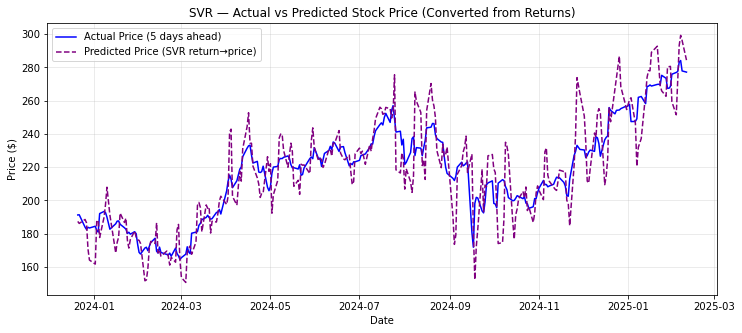

In [70]:

# Plot Actual vs Predicted Stock Prices (SVR Converted)


valid_dates = y_test.index[:len(predicted_prices)]

plt.figure(figsize=(12,5))
plt.plot(valid_dates, actual_future_prices, label="Actual Price (5 days ahead)", color="blue")
plt.plot(valid_dates, predicted_prices, label="Predicted Price (SVR return→price)", 
         color="purple", linestyle="--")

plt.title("SVR — Actual vs Predicted Stock Price (Converted from Returns)")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
